In [64]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
columns = ['vader_title','textblob_title', 'vader_description', 'textblob_description','harvard_title', 'mcdonald_title', 'harvard_description',
           'mcdonald_description']

In [3]:
def highlight(x):
    c1 = 'background-color: red'
    c2 = 'background-color: green' 
    checkList = x['diff%'] < 0
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1['diff%'] = np.where(checkList, c1, c2)
    return df1

In [5]:
folder = './news'
sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]

In [43]:
df_companies = pd.DataFrame()
for sub_folder in sub_folders:
    ticker = sub_folder
    path = folder + "/" + sub_folder
    df_bad = pd.read_csv(f'{path}/df_merged_bad.csv')
    df_best = pd.read_csv(f'{path}/df_merged_best.csv')
    df_stationary = pd.read_csv(f'{path}/df_merged_stationary.csv')
    
    #  доля позитивных новостей при росте акций
    proportion_pos_from_df_best = []
    size_df_best = len(df_best)
    for col in columns:
        proportion_pos_from_df_best.append(100 * len(df_best[df_best[col] == 'pos']) / size_df_best)

    #  доля позитивных новостей при падении акций
    proportion_pos_from_df_bad = []
    size_df_bad = len(df_bad)
    for col in columns:
        proportion_pos_from_df_bad.append(100 * len(df_bad[df_bad[col] == 'pos']) / size_df_bad)
        
    diff_proportion = [(a - b) for a, b in zip(proportion_pos_from_df_best, proportion_pos_from_df_bad)]
    
    data = {'company': ticker, 'sentiment_analysis': columns, 'pos_in_df_best': proportion_pos_from_df_best, 'pos_in_df_bad': proportion_pos_from_df_bad, 'diff%': diff_proportion}
    df = pd.DataFrame.from_dict(data)
    df_companies = df_companies.append(df, ignore_index=True)

In [44]:
df_companies_styler = df_companies.style.apply(highlight, axis=None)
df_companies_styler

<Figure size 1440x432 with 0 Axes>

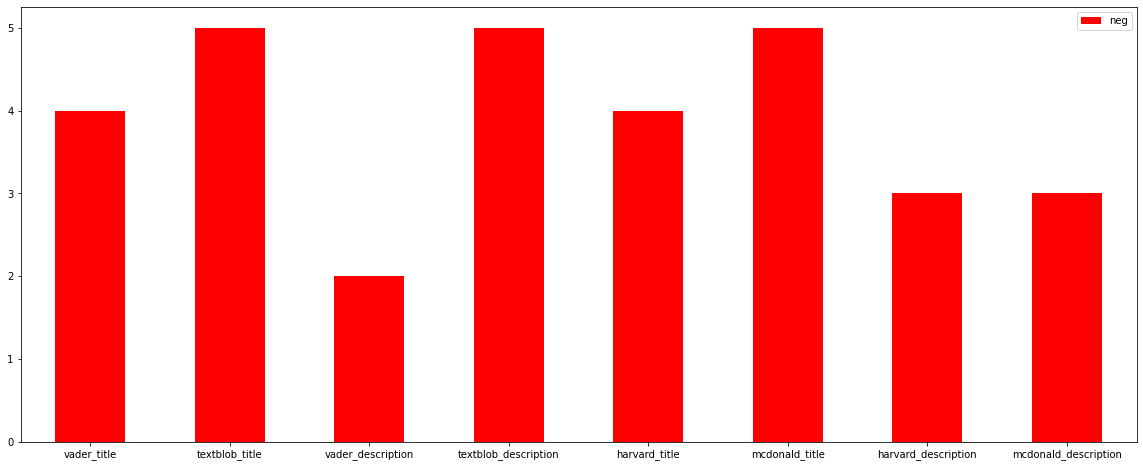

In [45]:
# График отражает сколько раз каждый сентиментальный анализ НЕ ПОКАЗАЛ роста положительного числа новостей при росте акции
# Всего 10 компаний, т.е чем больше выше гистограмма, тем хуже анализатор
fig = plt.figure(figsize=(20, 6))

count_neg = []
for col in columns:
    count_neg.append(len(df_companies[(df_companies['diff%'] < 0) & (df_companies['sentiment_analysis'] == col)]))

df1 = pd.DataFrame({'neg': count_neg}, index=columns)
ax = df1.plot.bar(rot=0, figsize=(20, 8), color='red')

In [46]:
df_companies.sort_values(by=['diff%'], ascending=False).head(10)

company    sentiment_analysis  pos_in_df_best  pos_in_df_bad      diff%
62   TCENY   harvard_description       78.048780      44.000000  34.048780
58   TCENY     vader_description       56.097561      28.000000  28.097561
60   TCENY         harvard_title       53.658537      32.000000  21.658537
26      FB     vader_description       52.702703      32.432432  20.270270
30      FB   harvard_description       59.459459      42.702703  16.756757
63   TCENY  mcdonald_description       26.829268      12.000000  14.829268
78     TSM   harvard_description       73.684211      59.259259  14.424951
56   TCENY           vader_title       29.268293      16.000000  13.268293
54    NVDA   harvard_description       59.336100      46.198830  13.137269
17   BRK-A        textblob_title       20.895522       8.510638  12.384884

Теперь воспользуемся файлами с новостями в дни, где цена акции лежит между 47.5 и 52.5 перцентилем.
Сравним долю позитивных новостей во время, когда цена акции не росла и не падала с долей, полученной вычитанием доли позитивных новостей в период роста акции и доли позитивных новостей в период падения акции

In [47]:
# найдем среднее по каждой метрике
df_median = df_companies[['sentiment_analysis', 'diff%']]
df_median = df_median.groupby(['sentiment_analysis']).mean()

In [48]:
#  Подгрузим из файла новости в дни, где цена акции лежит между 47.5 и 52.5 перцентилем
df_companies_stationary = pd.DataFrame()
for sub_folder in sub_folders:
    ticker = sub_folder
    path = folder + "/" + sub_folder
    df_stationary = pd.read_csv(f'{path}/df_merged_stationary.csv')
    
    #  доля позитивных новостей, когда акции не росли и не падали
    proportion_pos_from_df_stationary = []
    size_df_stationary = len(df_stationary)
    for col in columns:
        proportion_pos_from_df_stationary.append(100 * len(df_stationary[df_stationary[col] == 'pos']) / size_df_stationary)

    data = {'company': ticker, 'sentiment_analysis': columns, 'pos_in_df_stationary': proportion_pos_from_df_stationary}
    df = pd.DataFrame.from_dict(data)
    df_companies_stationary = df_companies_stationary.append(df, ignore_index=True)

In [49]:
df_median_from_file = df_companies_stationary[['sentiment_analysis', 'pos_in_df_stationary']]
df_median_from_file = df_median_from_file.groupby(['sentiment_analysis']).mean()

In [50]:
df_merged = pd.merge(df_median, df_median_from_file, how='inner', on='sentiment_analysis')
df_merged = df_merged.rename(columns={"diff%": "mean(pos in stocks rise - pos in stocks fall)", "pos_in_df_stationary": "pos when stock are stable"})
df_merged.sort_values(by=['mean(pos in stocks rise - pos in stocks fall)'], ascending=False)

mean(pos in stocks rise - pos in stocks fall)  \
sentiment_analysis                                                    
harvard_description                                        8.395691   
vader_description                                          6.804790   
mcdonald_description                                       3.273915   
harvard_title                                              2.418384   
vader_title                                                2.236969   
mcdonald_title                                             1.323315   
textblob_title                                             0.857536   
textblob_description                                      -0.708245   

                      pos when stock are stable  
sentiment_analysis                               
harvard_description                   57.275764  
vader_description                     49.692235  
mcdonald_description                  16.433689  
harvard_title                         46.528366  
vader_title                           37.251699  
mcdonald_title                        12.435093  
textblob_title                        13.165463  
textblob_description                  12.106305

In [51]:
# Создадим две выборки
# 1 - среднее количество позитивных новостей, когда цена акции росла (выборка A)
# 2 - среднее количество позитивных новостей, когда цена акции падала (выборка B)
A = df_companies[['sentiment_analysis', 'pos_in_df_best']]
A = A.groupby(['sentiment_analysis']).mean()


B = df_companies[['sentiment_analysis', 'pos_in_df_bad']]
B = B.groupby(['sentiment_analysis']).mean()

In [52]:
A

pos_in_df_best
sentiment_analysis                  
harvard_description        60.138661
harvard_title              45.739998
mcdonald_description       18.940098
mcdonald_title             11.546443
textblob_description       12.391011
textblob_title             13.838226
vader_description          51.342388
vader_title                39.128482

In [53]:
B

pos_in_df_bad
sentiment_analysis                 
harvard_description       51.742971
harvard_title             43.321615
mcdonald_description      15.666183
mcdonald_title            10.223127
textblob_description      13.099256
textblob_title            12.980690
vader_description         44.537598
vader_title               36.891513

In [72]:
C[C['sentiment_analysis']=='harvard_title']

sentiment_analysis  pos_in_df_best
4       harvard_title       44.609665
12      harvard_title       41.121495
20      harvard_title       43.283582
28      harvard_title       40.990991
36      harvard_title       41.592920
44      harvard_title       49.769585
52      harvard_title       52.697095
60      harvard_title       53.658537
68      harvard_title       42.307692
76      harvard_title       47.368421

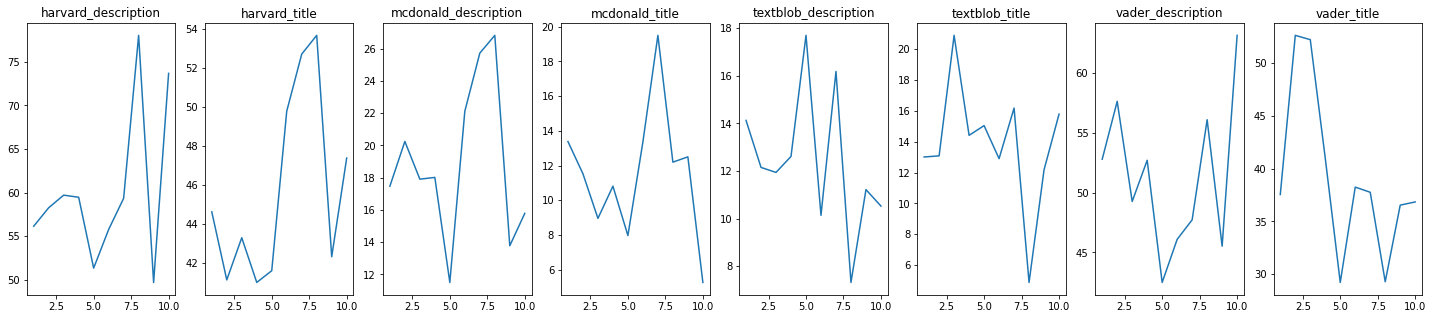

In [94]:
C = df_companies[['sentiment_analysis', 'pos_in_df_best']]
i = 0
fig, axs = plt.subplots(1, 8, figsize=(25, 5))
x = list(range(1, 11))
for group_name, df_group in C.groupby(['sentiment_analysis']): 
    y = df_group['pos_in_df_best']
    axs[i].plot(x, y)
    axs[i].set_title(group_name)
    i += 1